In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

%cd ..
from utils import *

/scratch2/jsalle/ObsScaling


In [2]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval()
eval_result_path = "./eval_results/base_llm_post_training_eval.csv"
post_training_eval = pd.read_csv(eval_result_path)

# Merge 
base_llm_eval_with_post_training = pd.merge(base_llm_benchmark_eval, post_training_eval, on="Model")

SCALING_SETUP_KWARGS = {
    # Data preprocessing: PCA imputation and extraction
    **NONGSM_PCA_PREPROCESS_KWARGS,  # exclude GSM to avoid making the task trivial, e.g., using GSM to predict GSM
    
    # Non-lineariy: sigmoid with parametrized scale and shift
    "nonlinearity": "sigmoid-parametric", 

    # Cutoff: 8.4E22 FLOPs corresponding to LLama-2 7B
    "split_method": "cutoff_by_FLOPs (1E21)",
    "cutoff_threshold": 84,

    # Model families: include all we have evaled
    "df_filter": lambda x: x['Model Family'].isin(EVAL_BASE_MODEL_FAMILIES),   
    "df_groupby": 'Model Family',  # group markers by model family

    # Regression: ordinary least squares
    "reg_method": "robust",  
    "reg_kwargs": {"delta": 1.0},  # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS
}

PLOT_X_METRICS_LIST = [MODEL_SIZE_METRIC, TRAINING_FLOPS_METRIC, PC_METRIC_NUM_3]   # plot scaling comparison w.r.t. model size, training FLOPs, and 3 PCs

### GSM8K

In [4]:
## GSM8K eval metrics with CoT and self-consistency
GSM8K_METHOD_SCALING_COT_METRIC_MAP = {
    'gsm8k_5_exact_match,flexible-extract': "Naive + Greedy",
    'gsm8k_cot_8_exact_match,flexible-extract': "CoT + Greedy",
}

GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP = {
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': "CoT + 1 Sample",
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': "CoT + SC + 5 Samples",
}

GSM8K_METHOD_SCALING_ORIG_METRIC_MAP = {
    **GSM8K_METHOD_SCALING_COT_METRIC_MAP,
    **GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP,
}

GSM8K_COT_SCALING_METRICS = list(GSM8K_METHOD_SCALING_COT_METRIC_MAP.keys())
GSM8K_SELFCONS_SCALING_METRICS = list(GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP.keys())

GSM8K_METHOD_SCALING_METRICS = [
    'gsm8k_5_exact_match,flexible-extract',
    'gsm8k_cot_8_exact_match,flexible-extract',
    # 'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract',
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract',
]

In [5]:
color_palette = sns.color_palette()

GSM8K_METHOD_SCALING_COLOR_MAP = {
    'gsm8k_5_exact_match,flexible-extract': color_palette[1],
    'gsm8k_cot_8_exact_match,flexible-extract': color_palette[0],
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': color_palette[0],
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': color_palette[2],
}


GSM8K_SETUP_SPECIFIC_KWARGS = {}
for e in GSM8K_METHOD_SCALING_METRICS:
    GSM8K_SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": GSM8K_METHOD_SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }

    if e != "gsm8k_5_exact_match,flexible-extract":
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["plot_adjust_kwargs"].update({"ylim": [-0.03, 0.97]})
    if e in ["gsm8k_5_exact_match,flexible-extract"]:
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["grace_range_ratios"] = [0.05, 0.12]


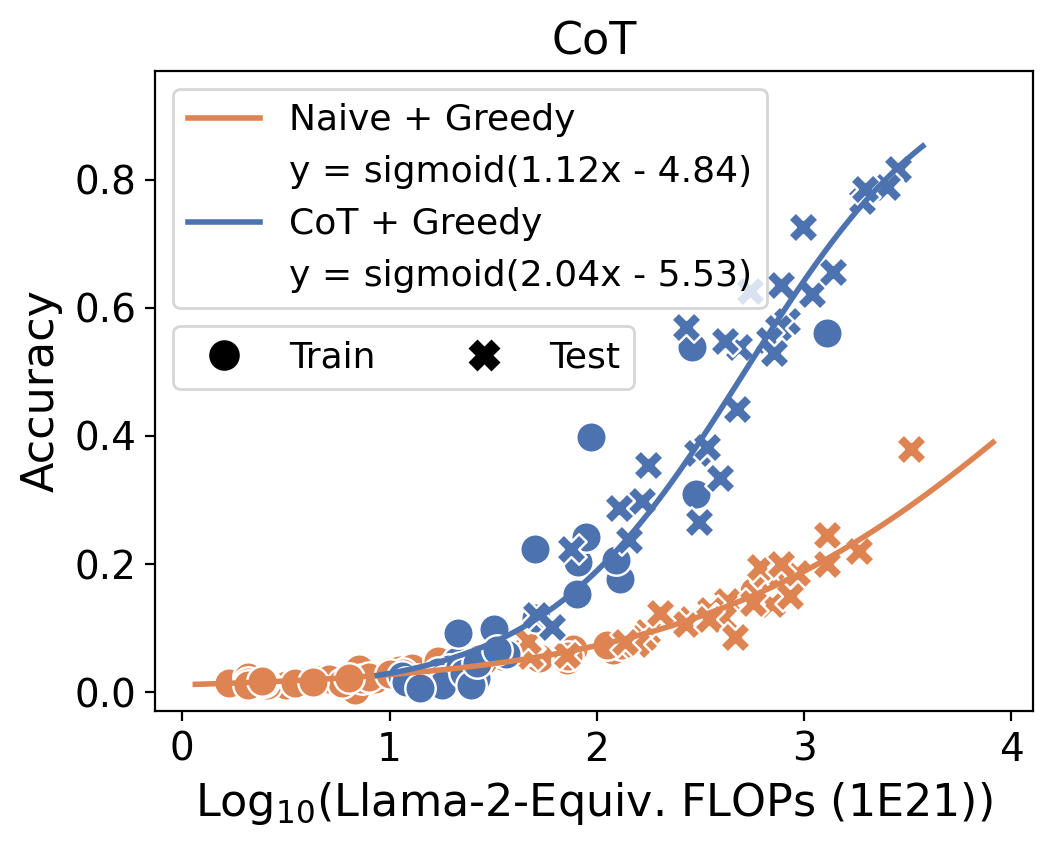

In [6]:
fig, fit_results = plot_scaling_comparison_multi_metrics(
    base_llm_eval_with_post_training, GSM8K_COT_SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS, y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP, ymetric2color_map=GSM8K_METHOD_SCALING_COLOR_MAP,
    plot_title="CoT"
)

/scratch2/jsalle/ObsScaling/utils/plot.py:808: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


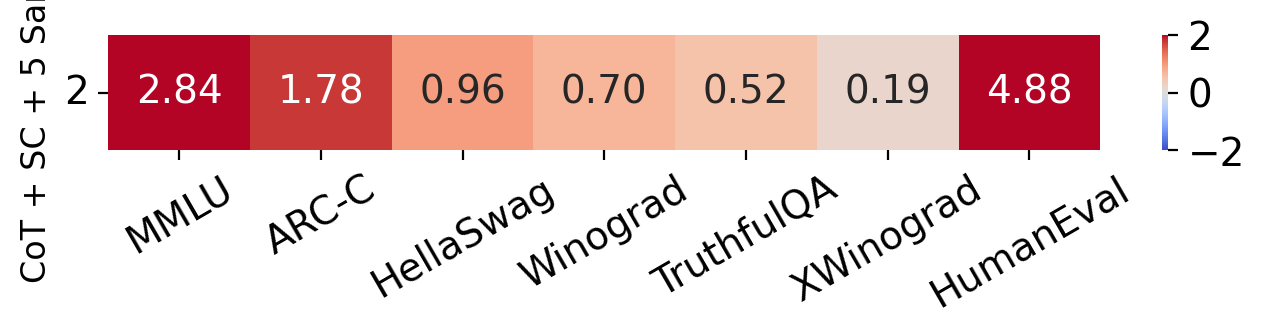

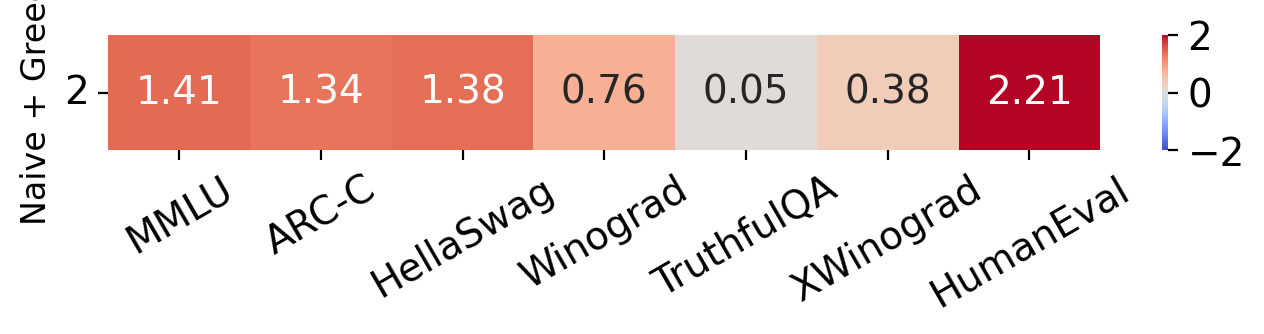

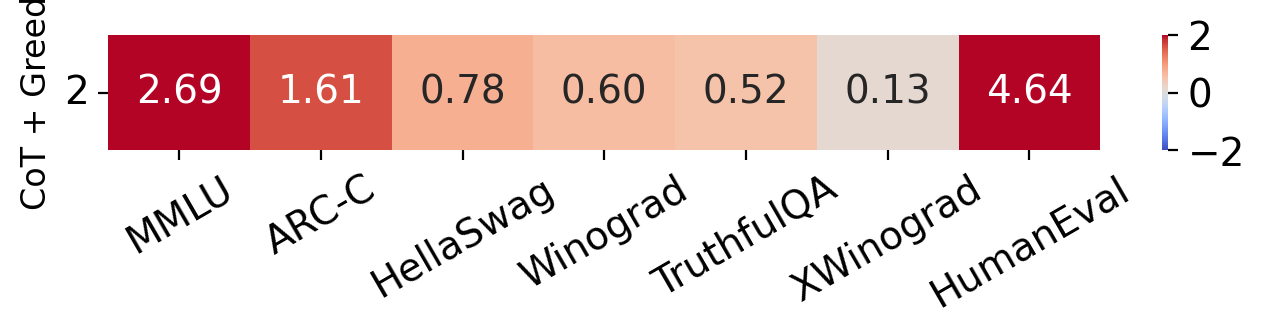

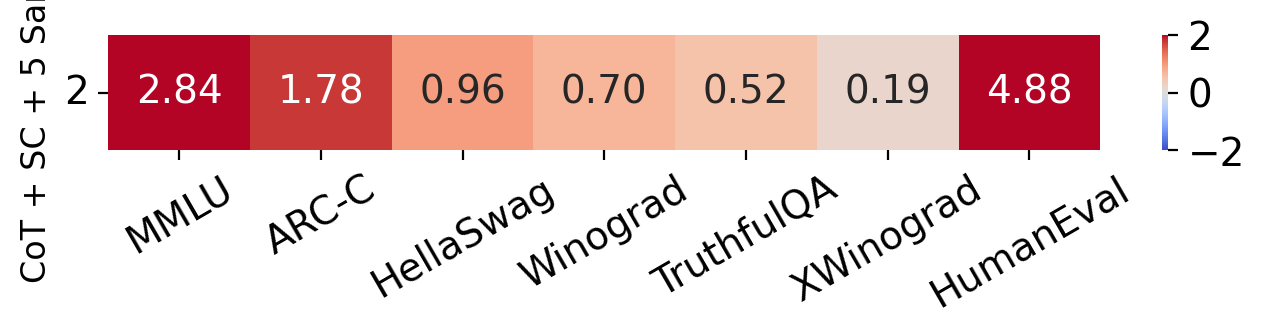

In [7]:
## Generate weights 
plot_weight_analysis(
    base_llm_eval_with_post_training, 
    y_metrics=GSM8K_METHOD_SCALING_METRICS, 
    x_metrics_list=[PC_METRIC_NUM_2], 
    analysis_setup_kwargs=SCALING_SETUP_KWARGS, 
    #y_metric_specific_kwargs=None, 
    filter_model_family=EVAL_BASE_MODEL_FAMILIES, # not default
    norm_weights=False,
    remove_y_ticks=False,
)

In [8]:
pca_weights = fit_results["popt"][1:]  # optimal weights end to end, excluding the intercept
pca_weights = np.expand_dims(pca_weights, axis=0)  # shape (1, num_pc_used)
pca_components = fit_results["pca_components"][:3]  # shape (num_pc_used, num_metrics_used)

metric_weights = pca_weights.dot(pca_components)

### BigBench-Hard

/scratch2/jsalle/ObsScaling/utils/plot.py:829: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(5.5 * len(x_metrics_list), 4.5))
/scratch2/jsalle/ObsScaling/utils/data.py:443: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-x)) + b
/scratch2/jsalle/ObsScaling/utils/data.py:443: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-x)) + b
/scratch2/jsalle/ObsScaling/utils/data.py:443: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-x)) + b


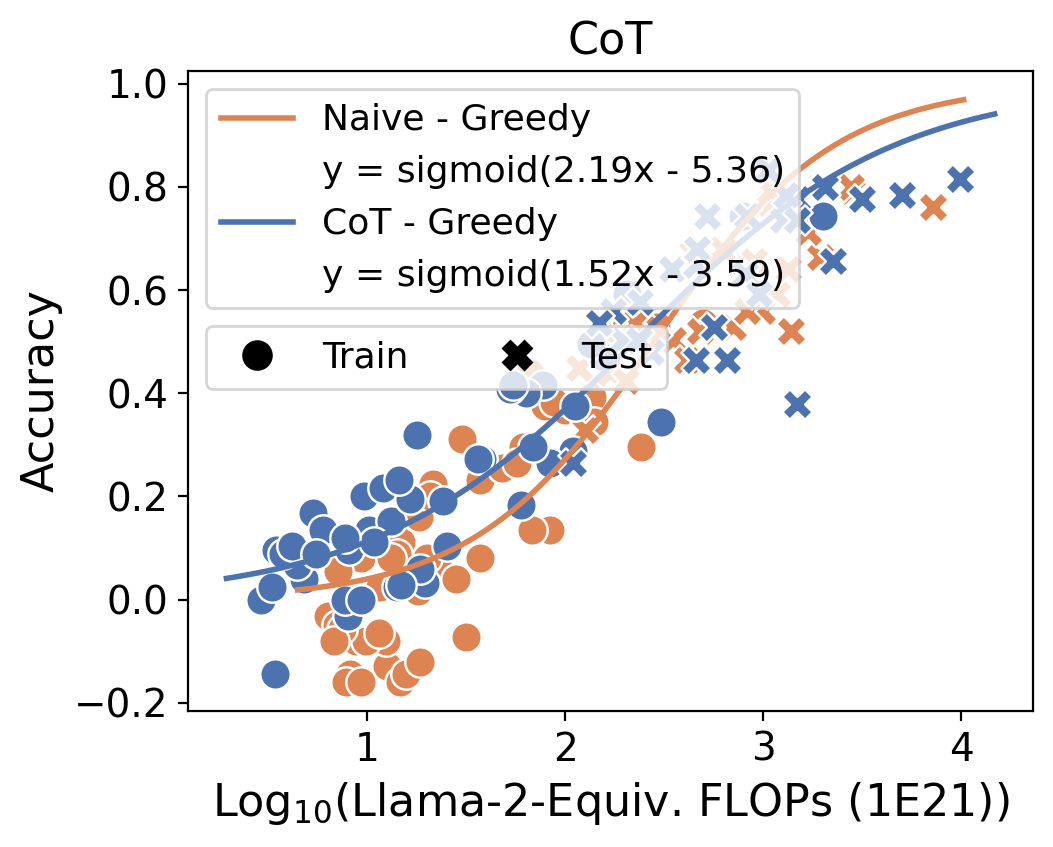

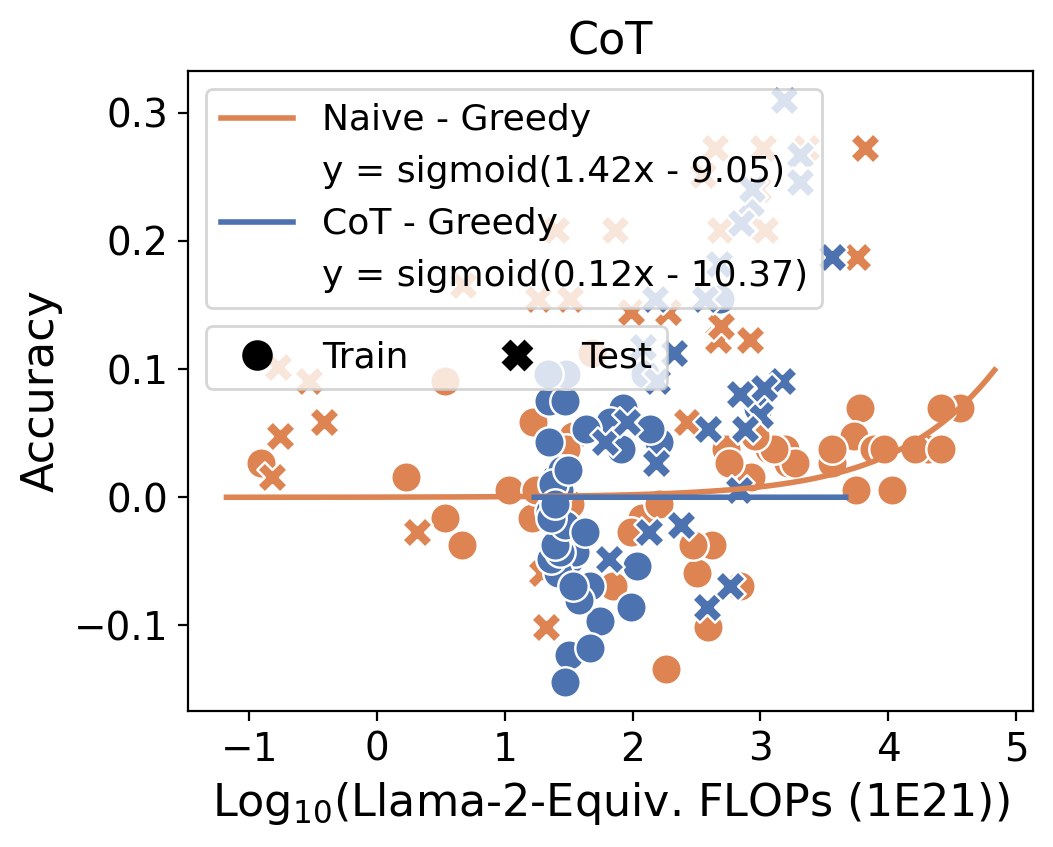

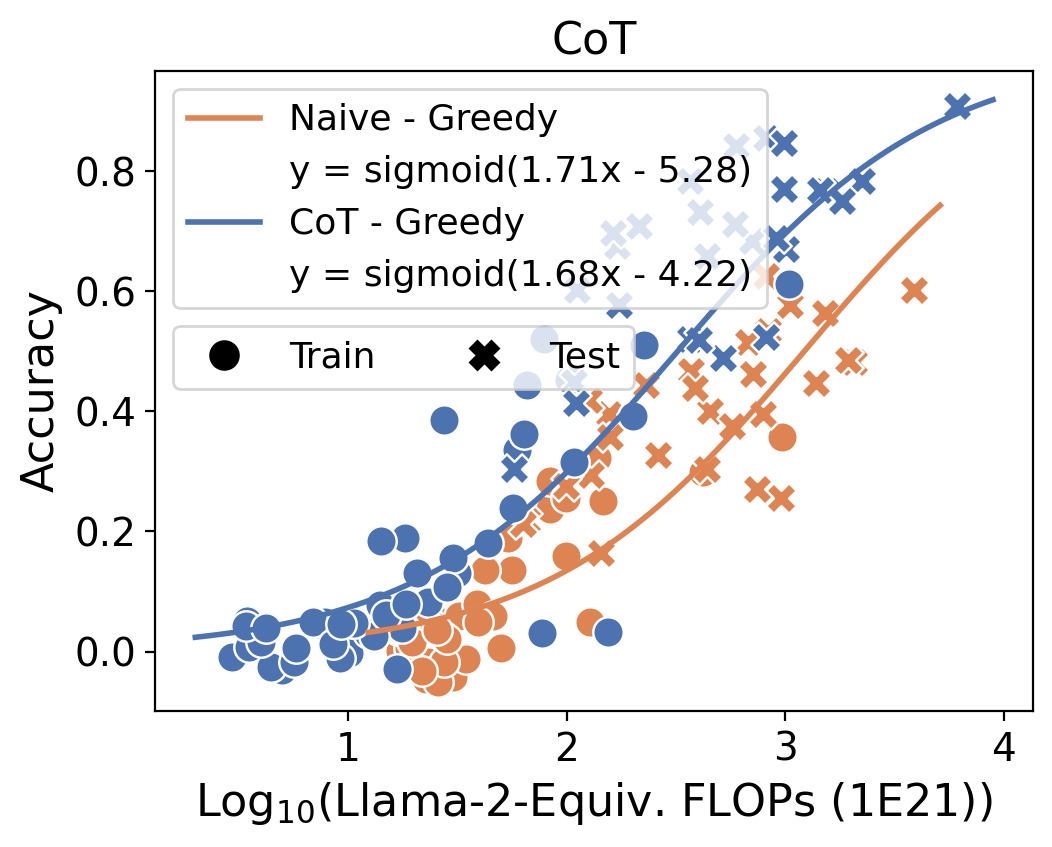

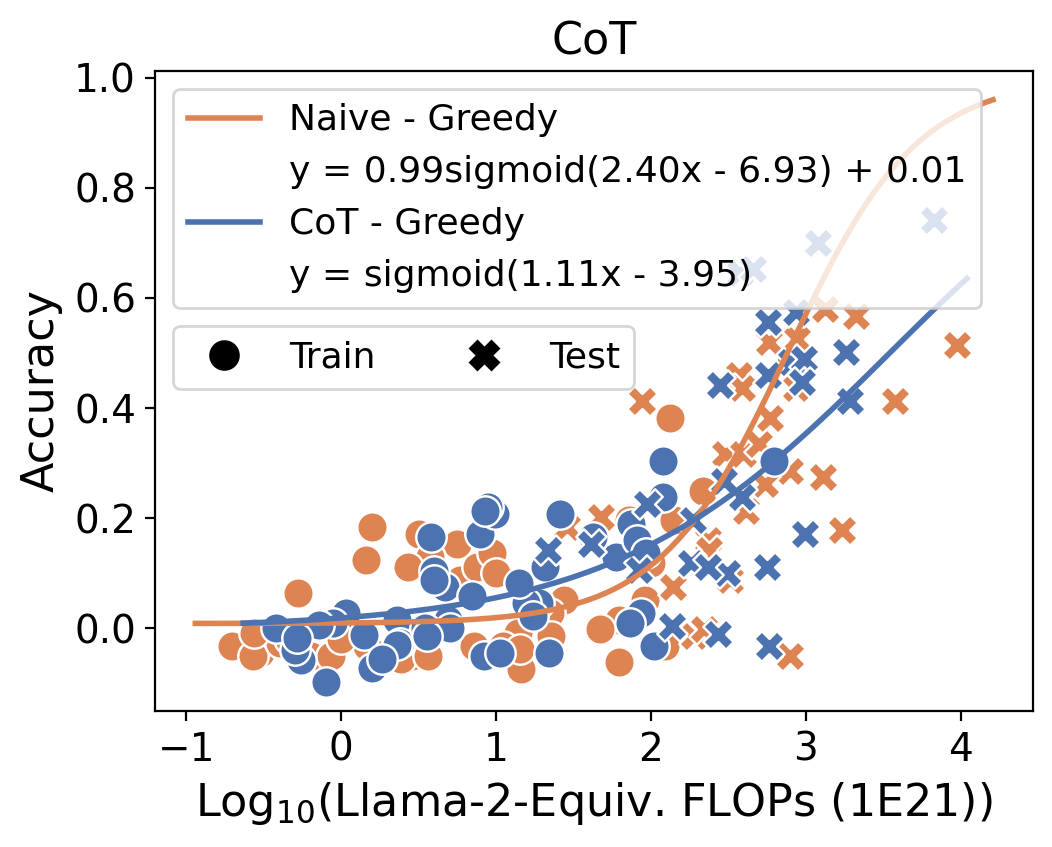

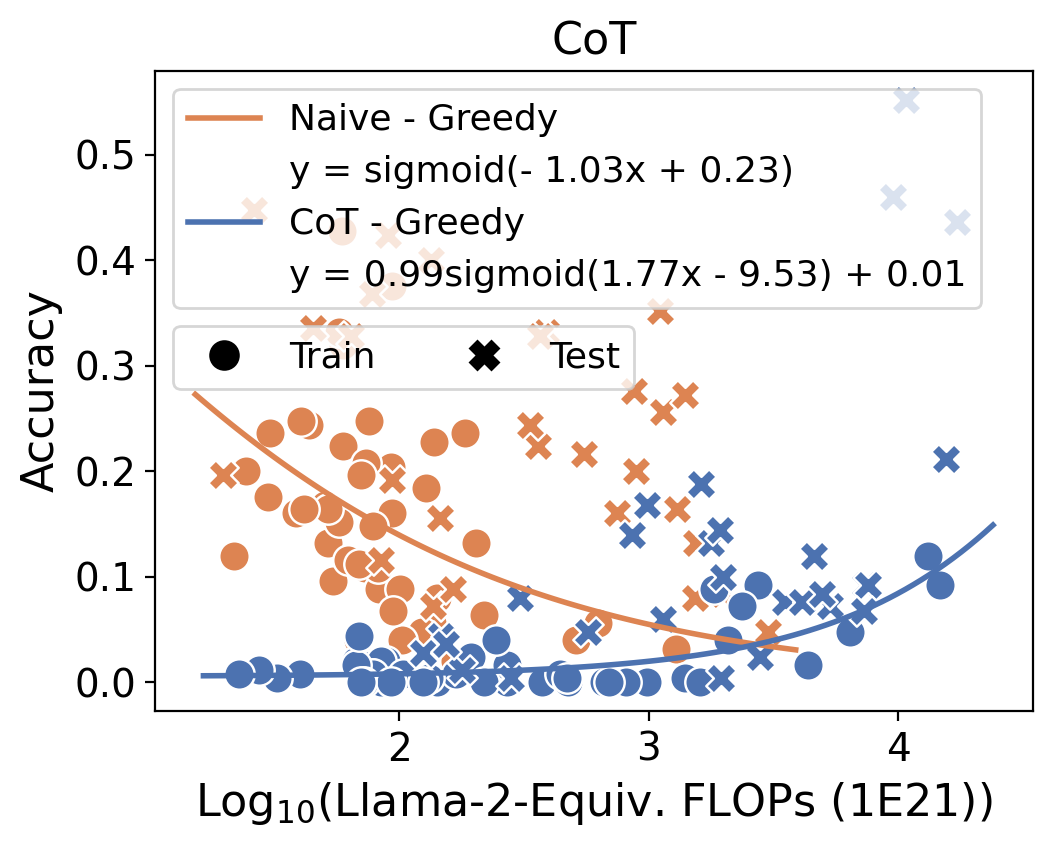

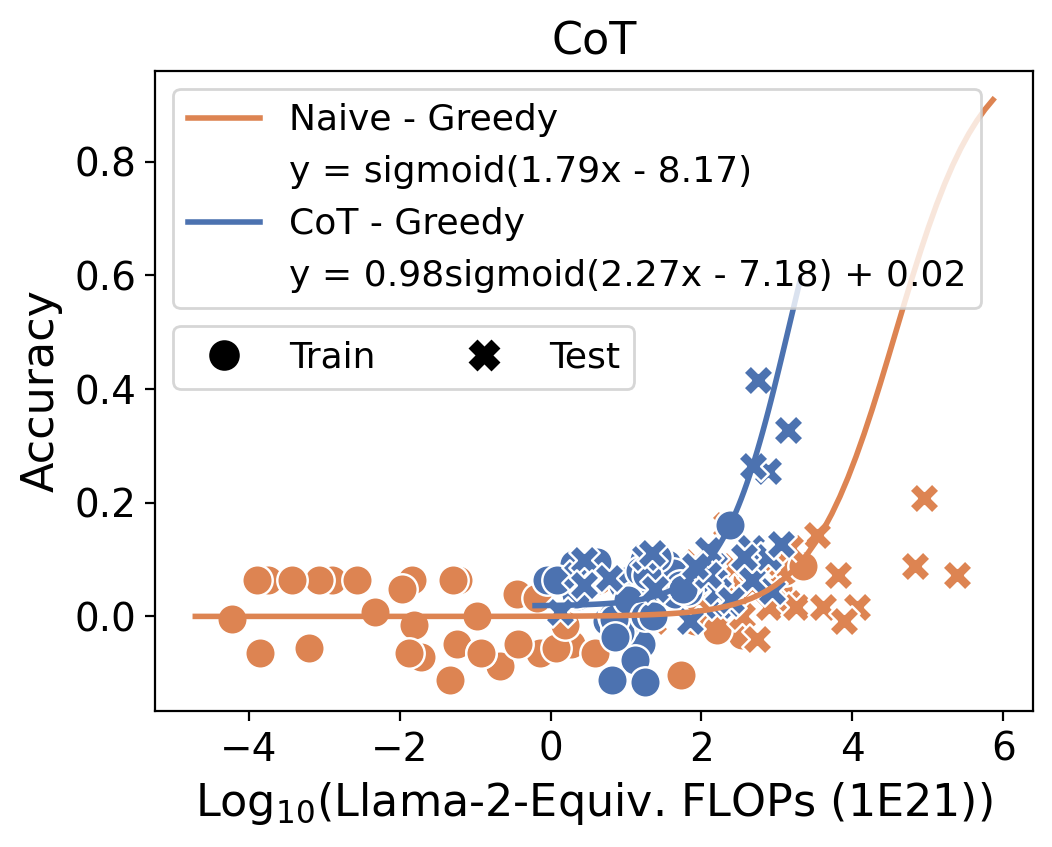

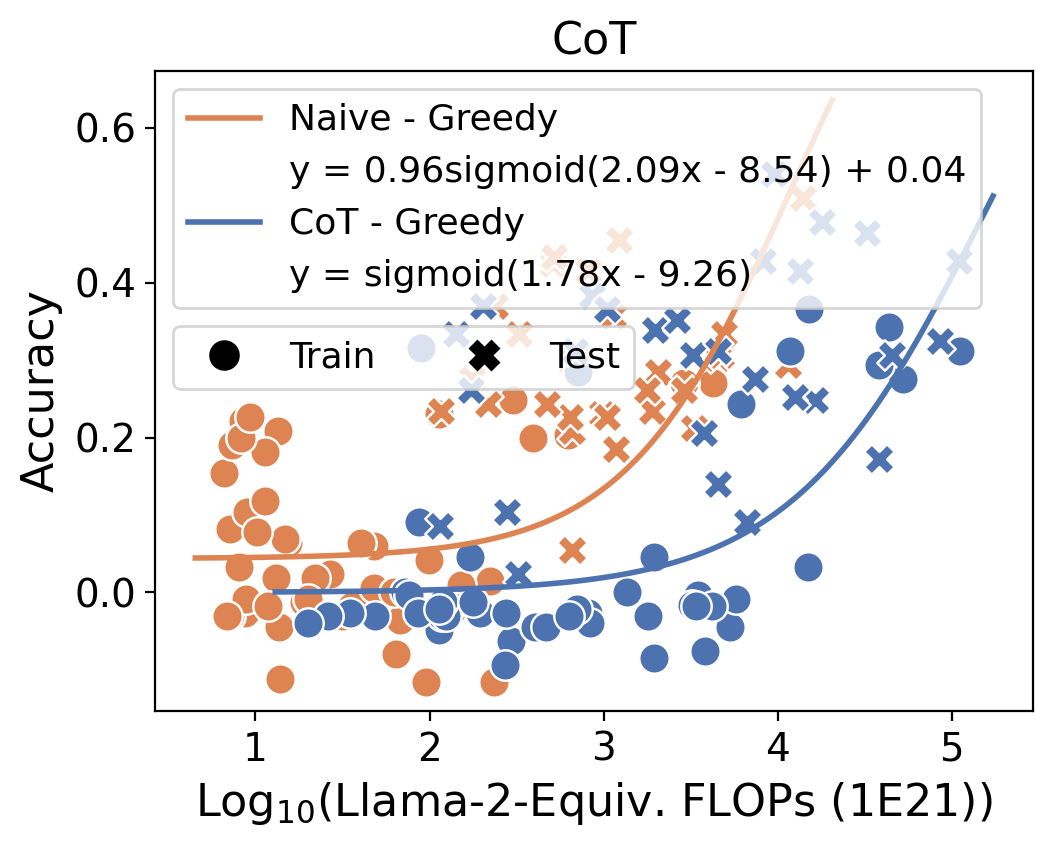

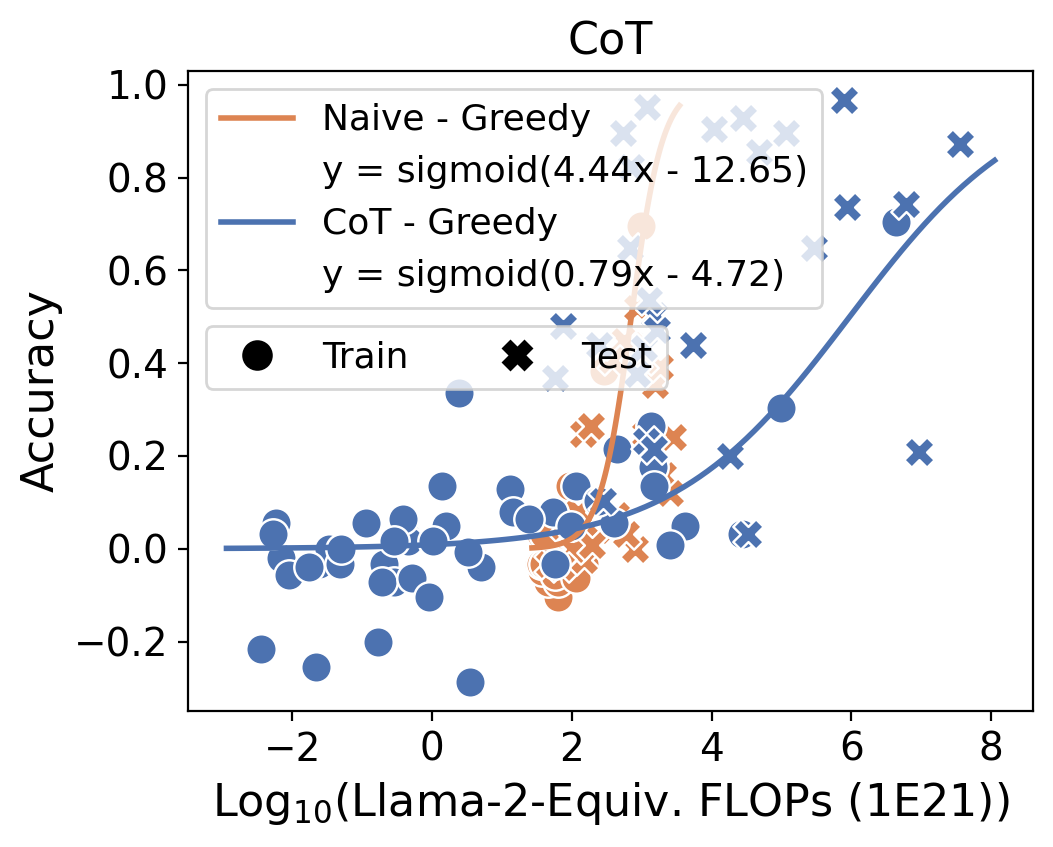

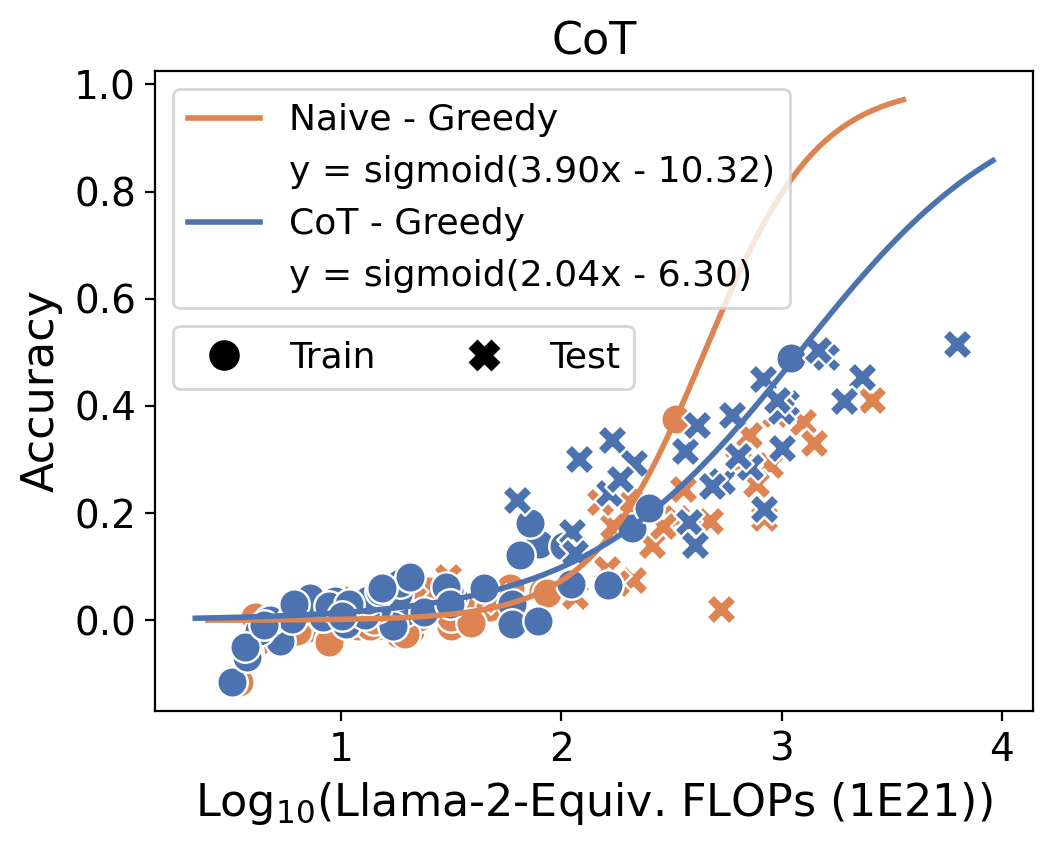

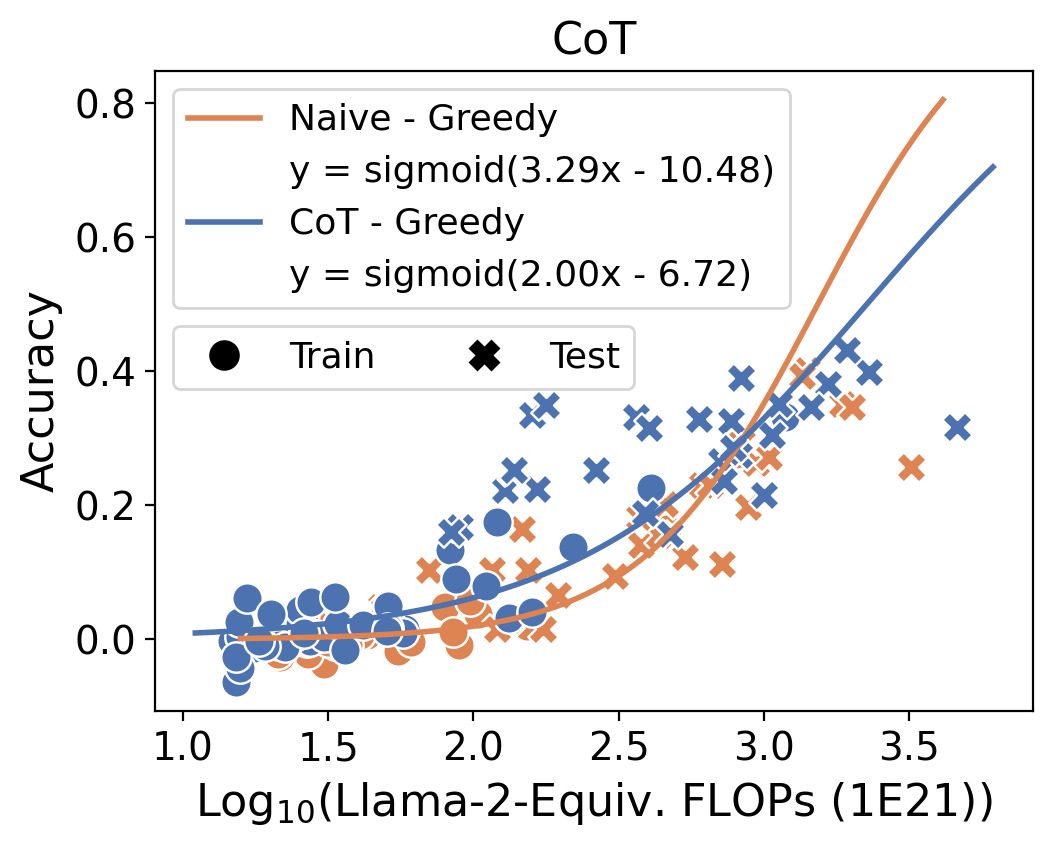

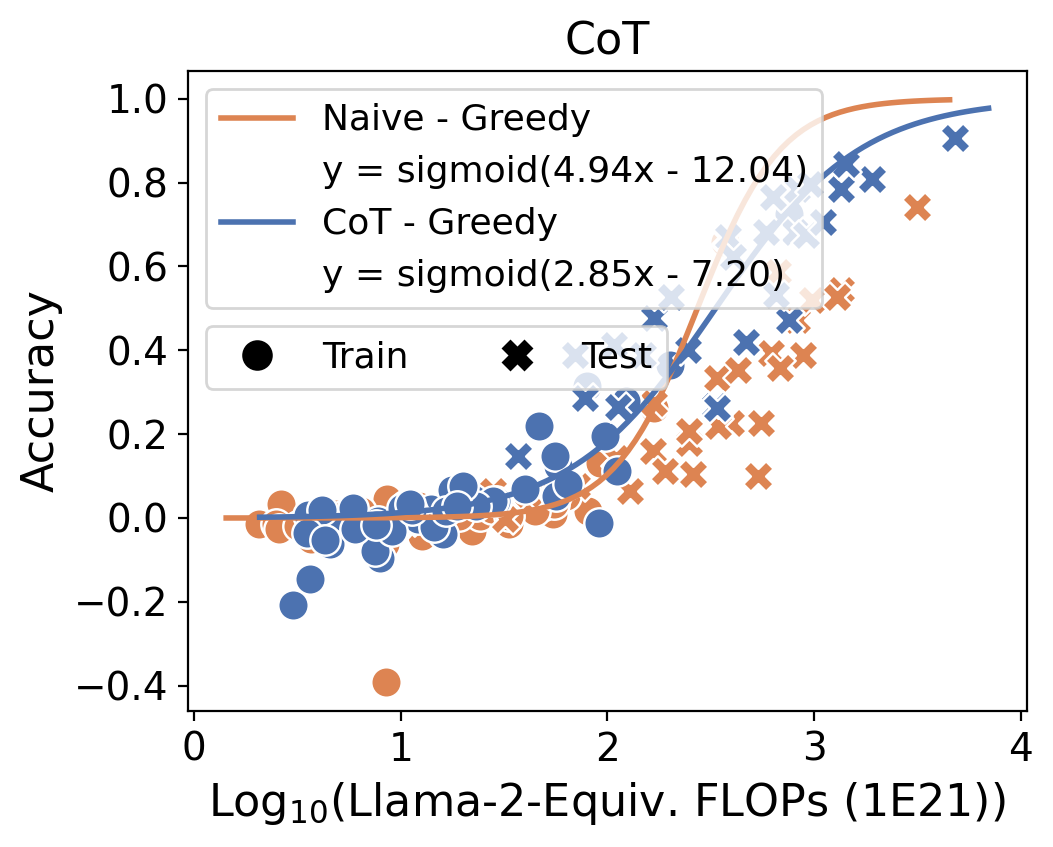

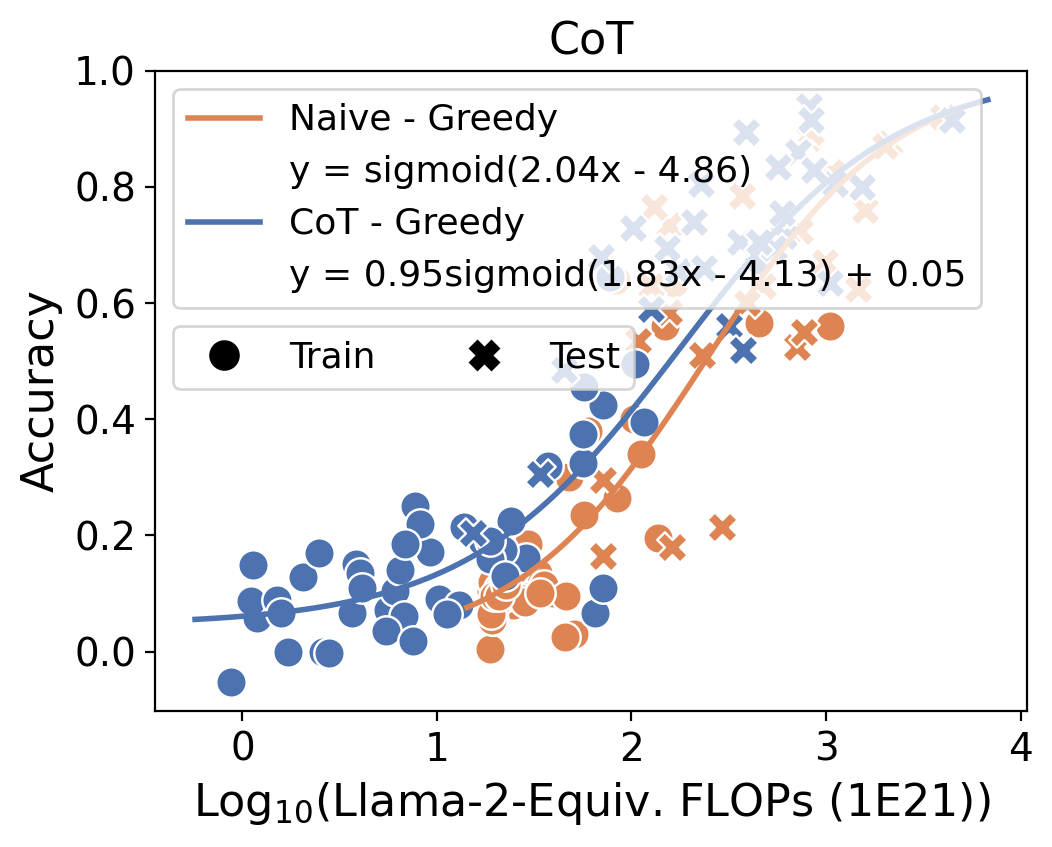

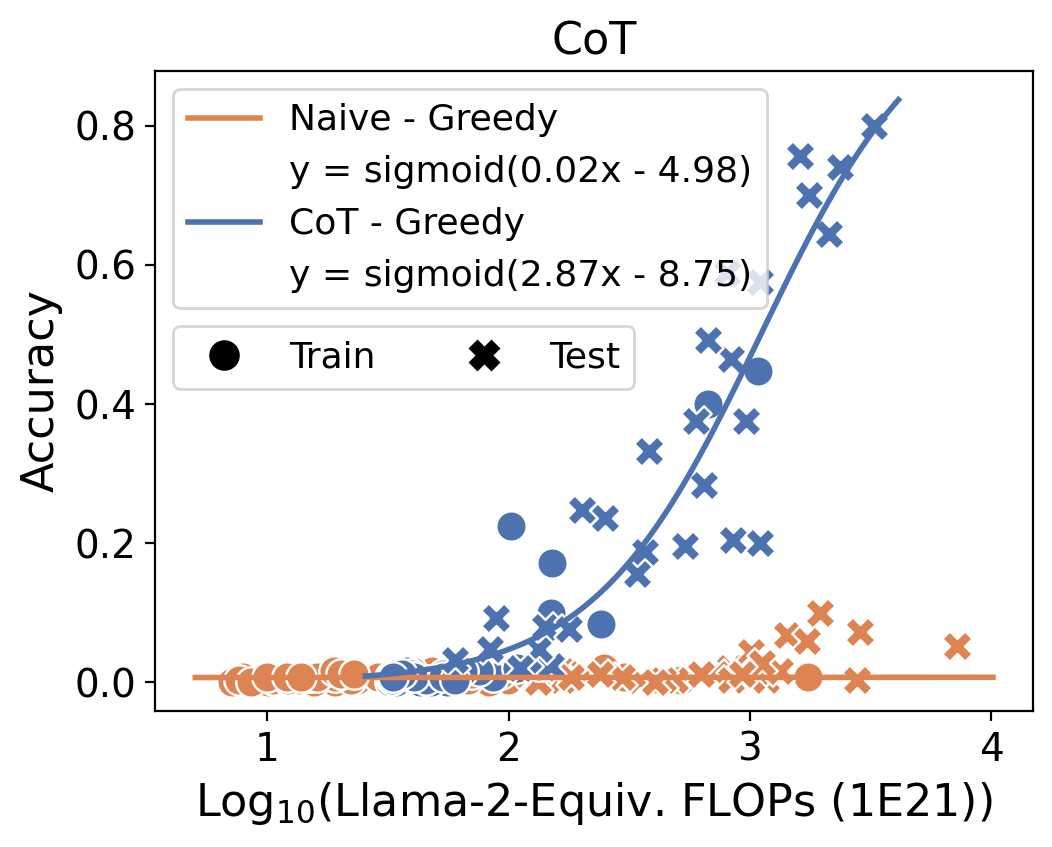

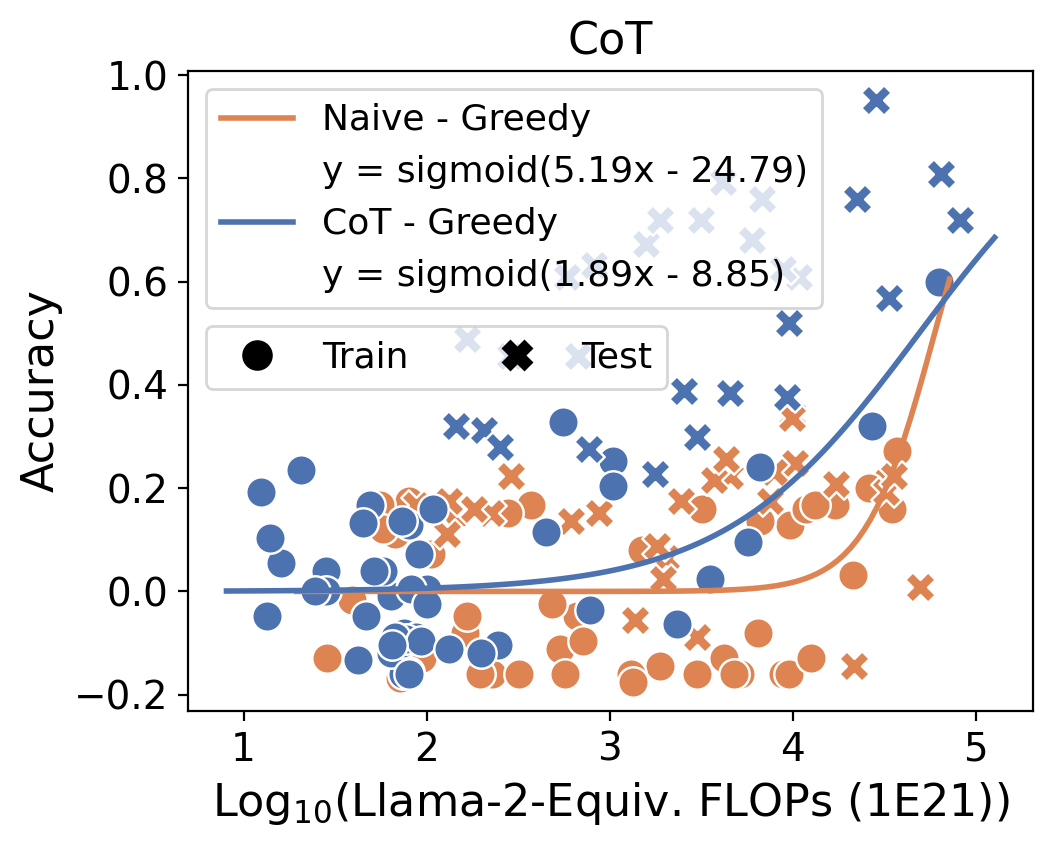

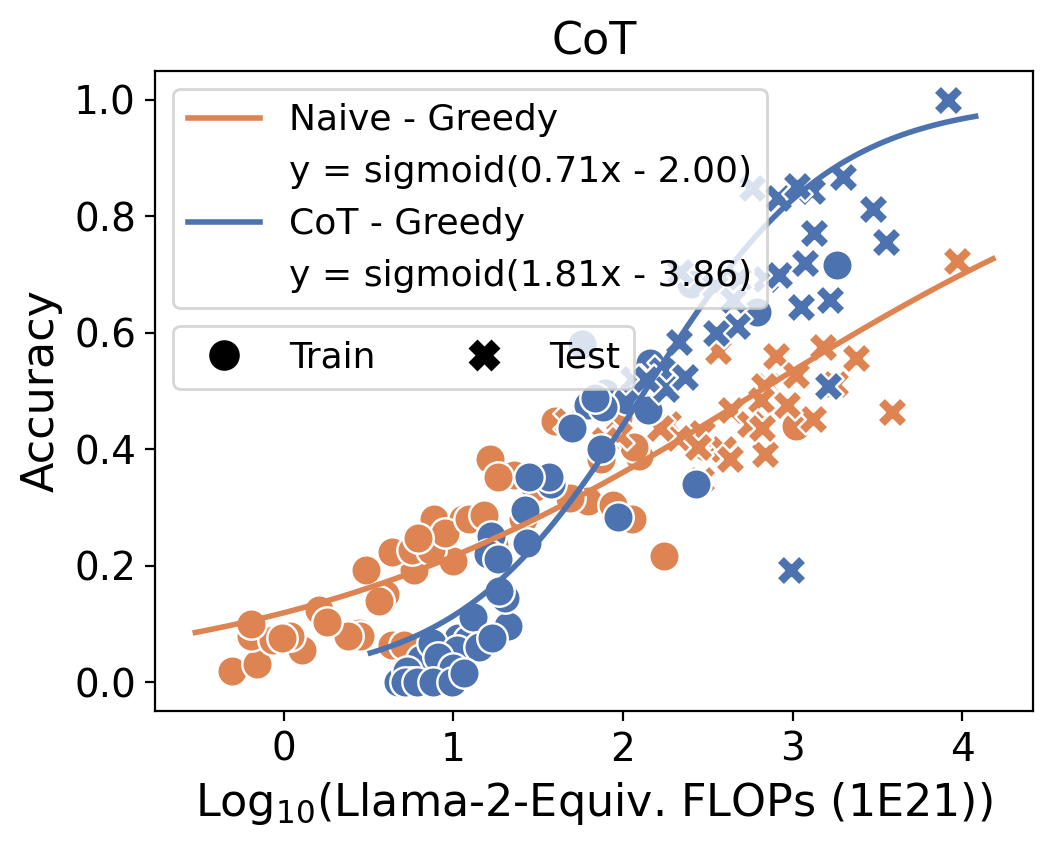

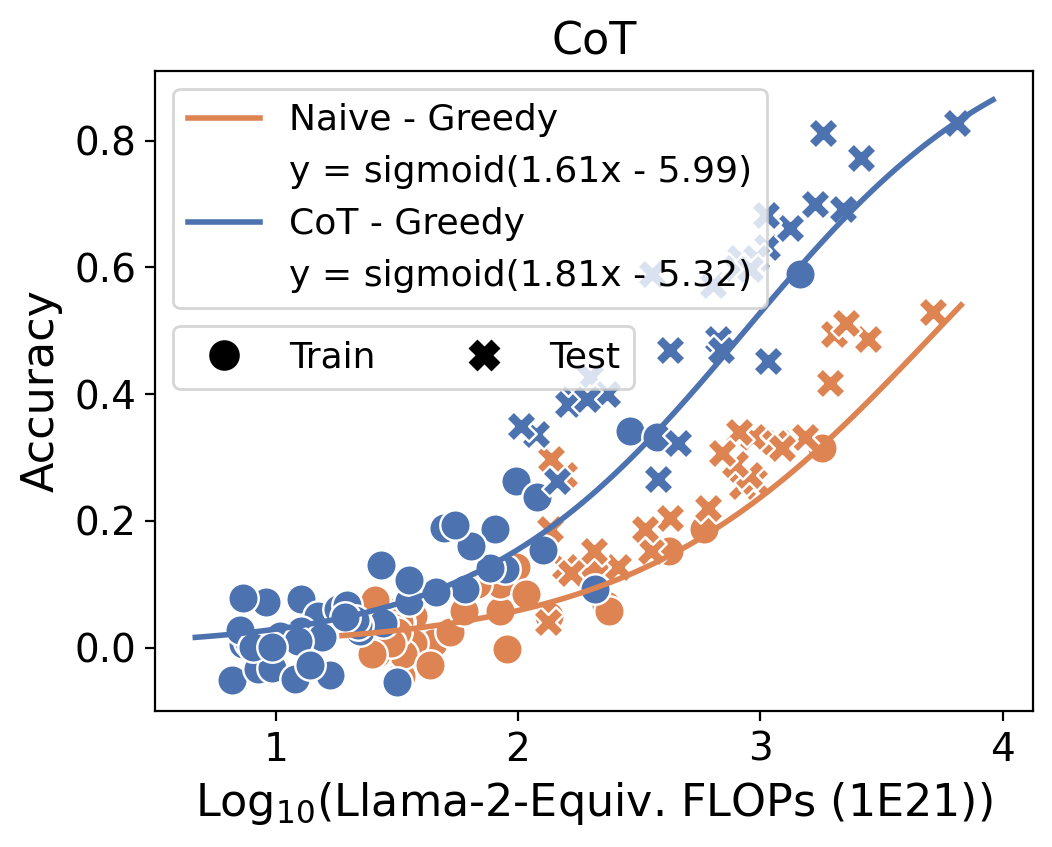

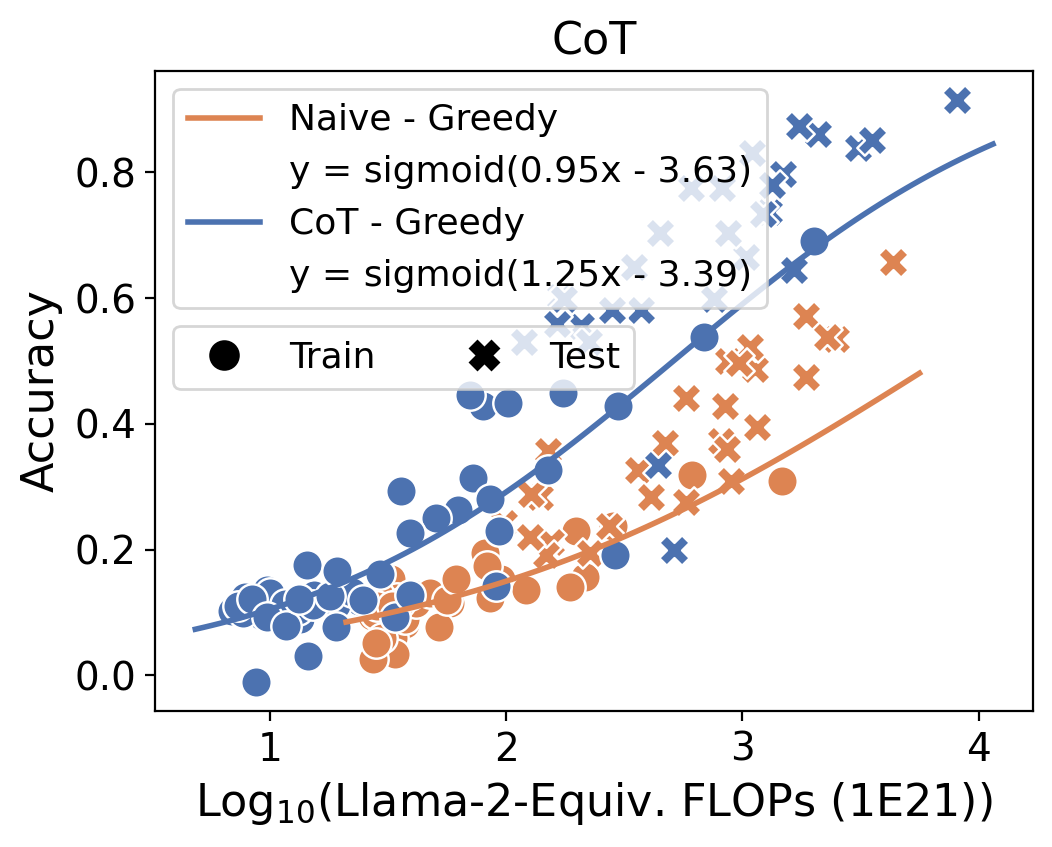

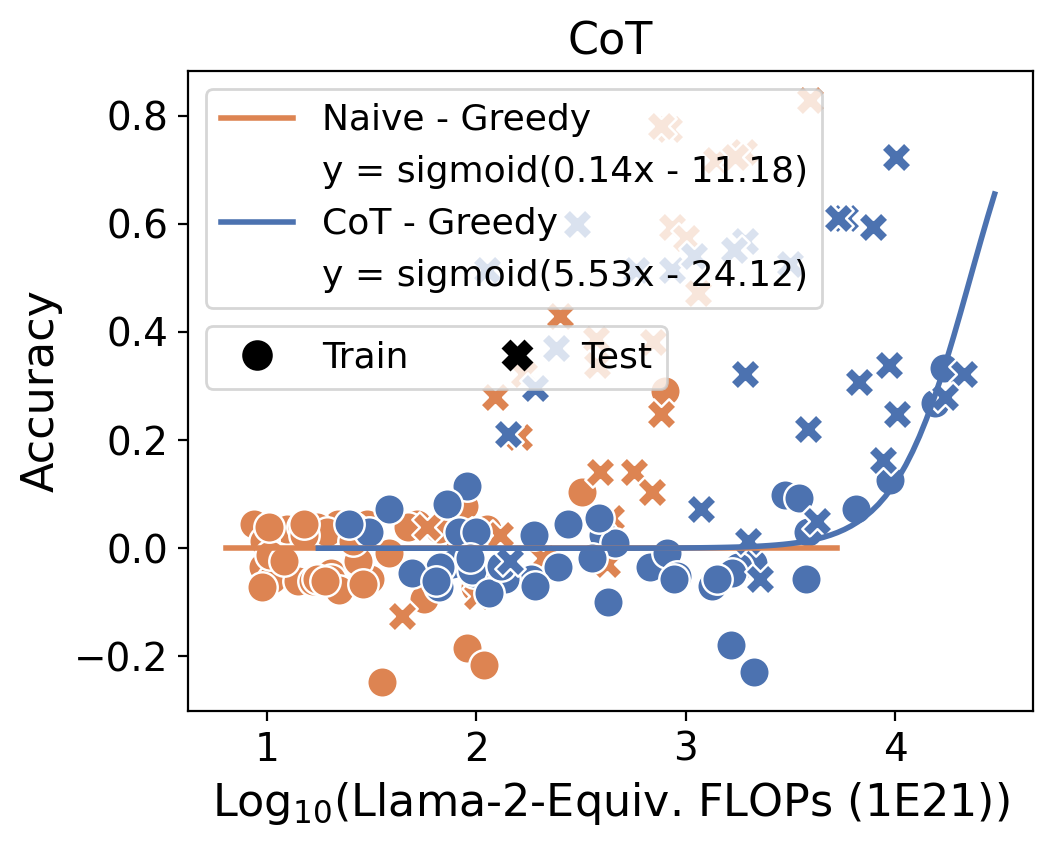

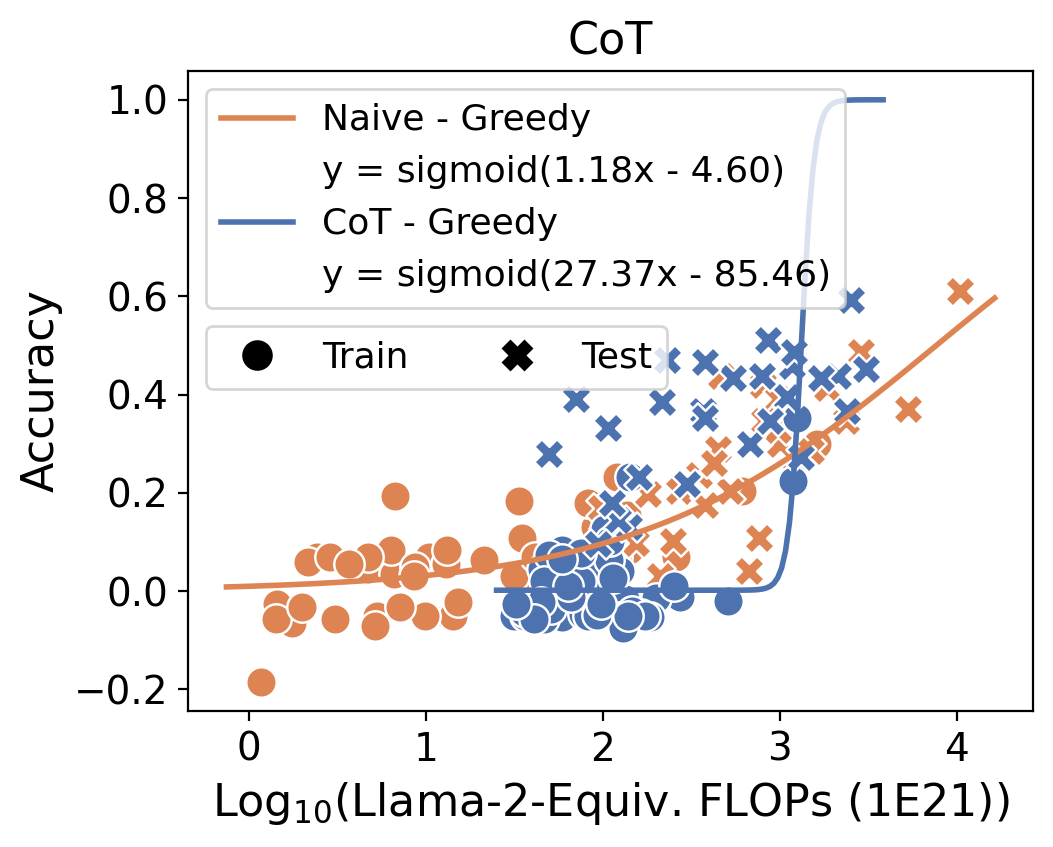

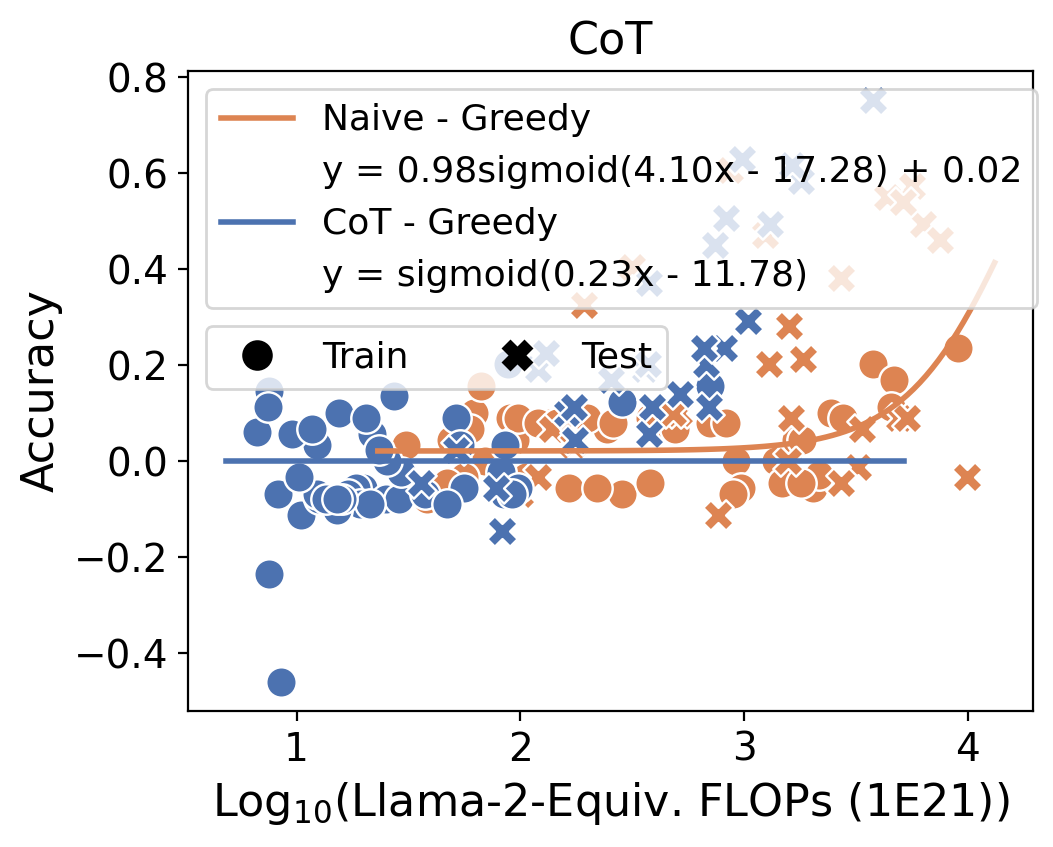

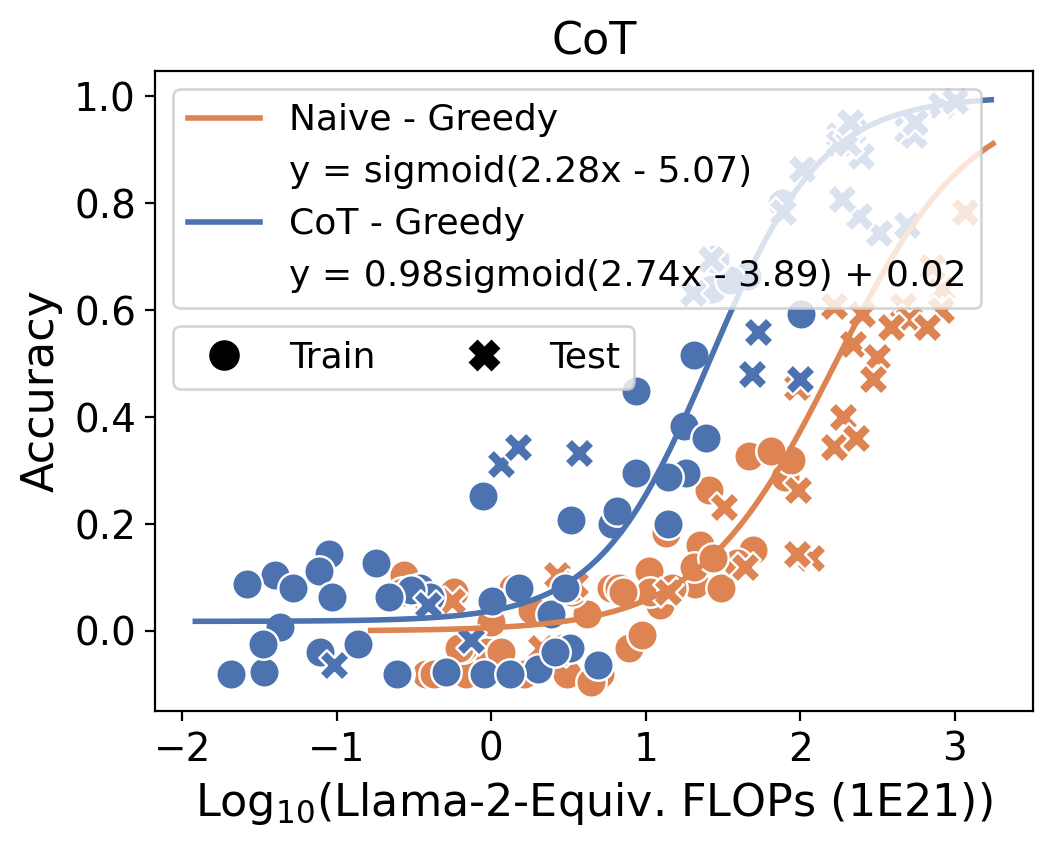

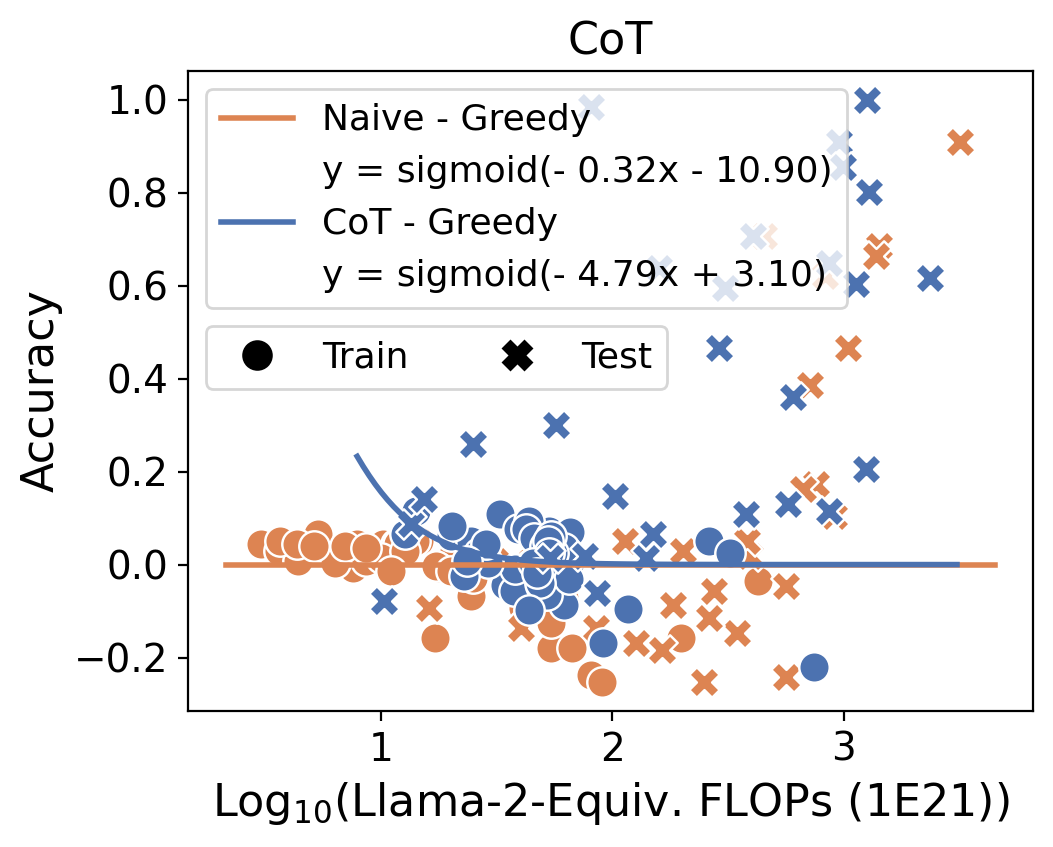

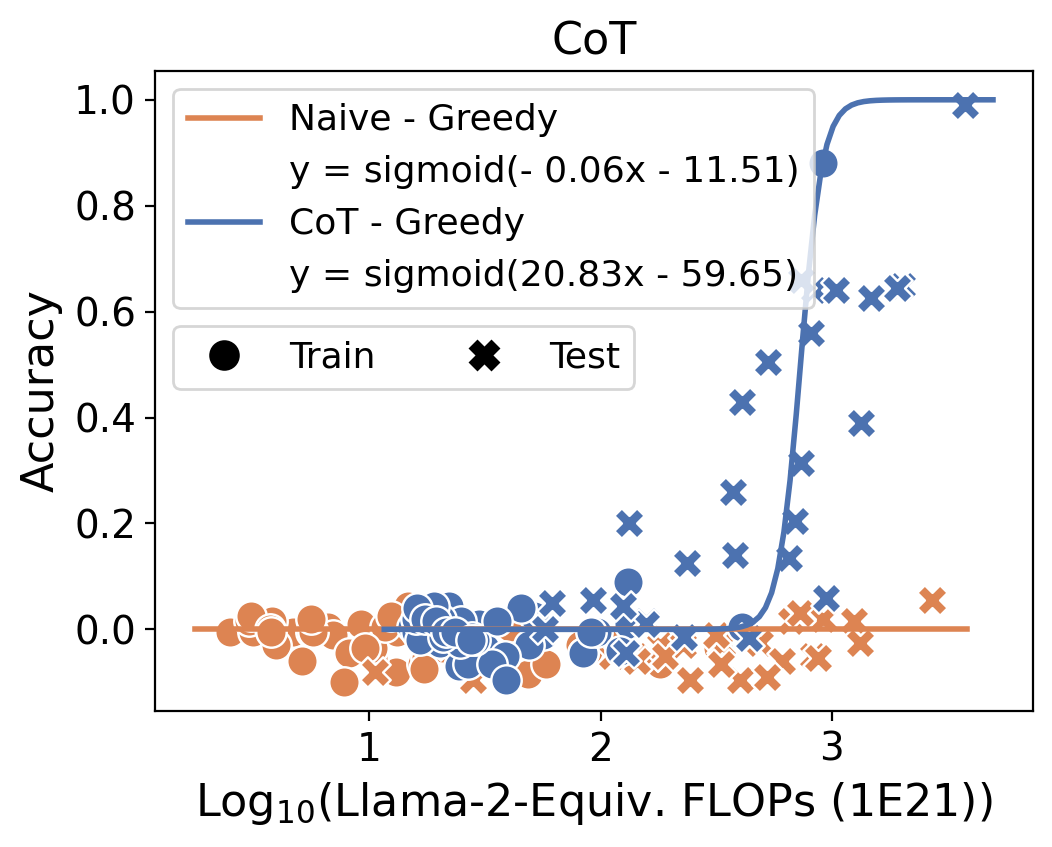

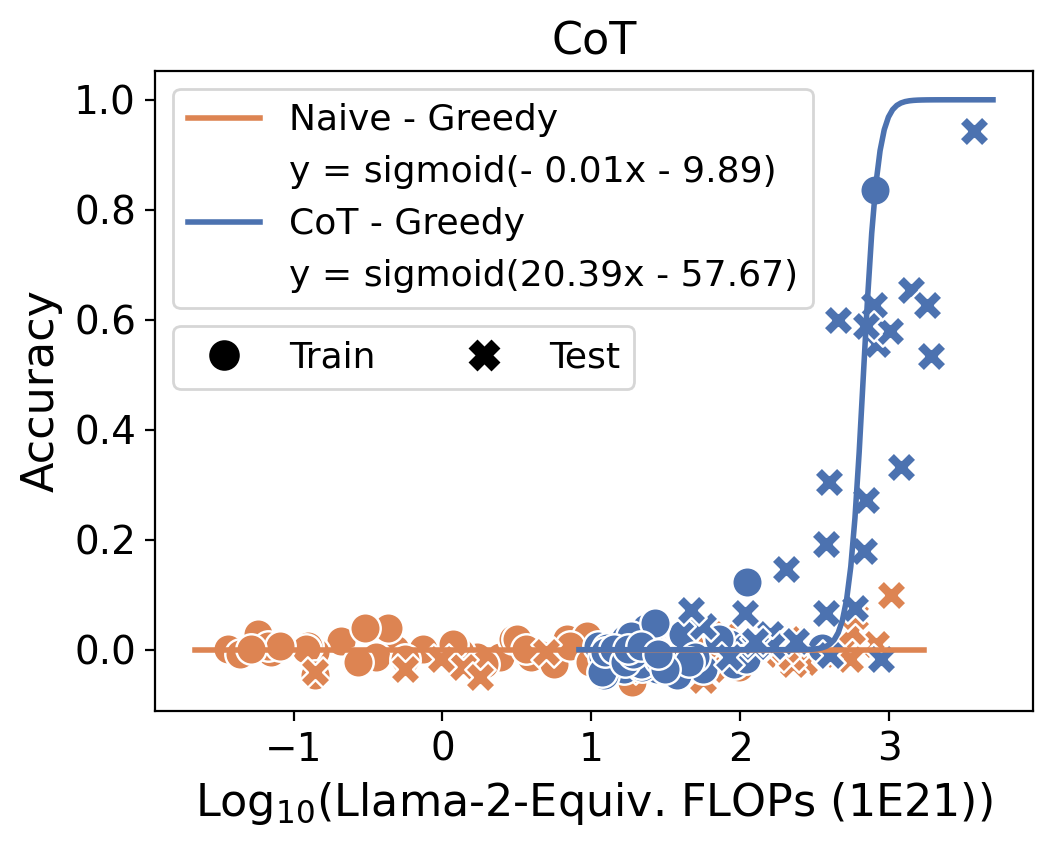

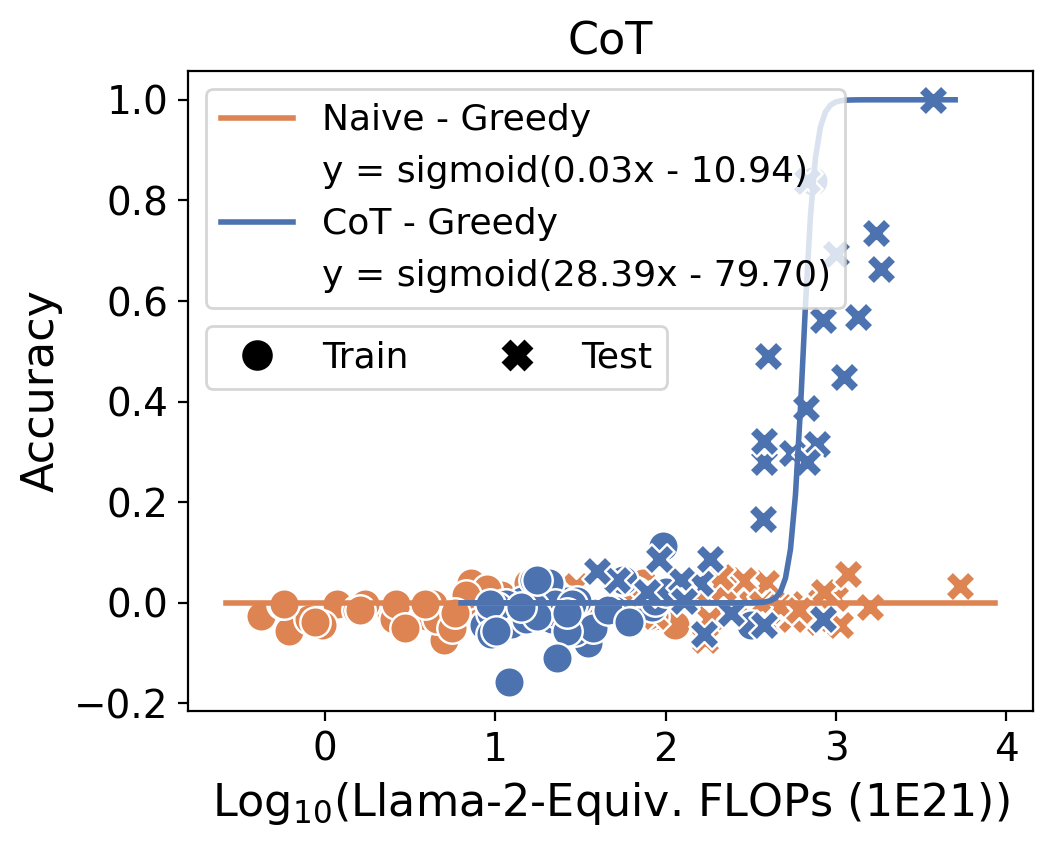

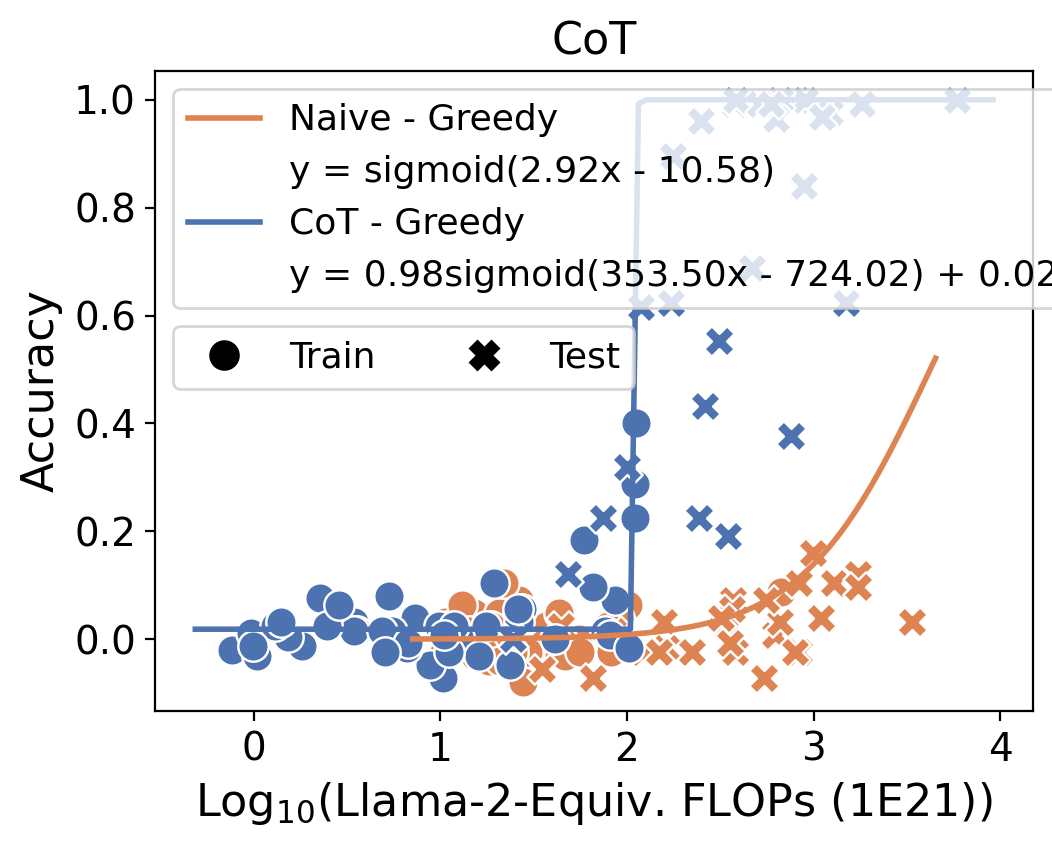

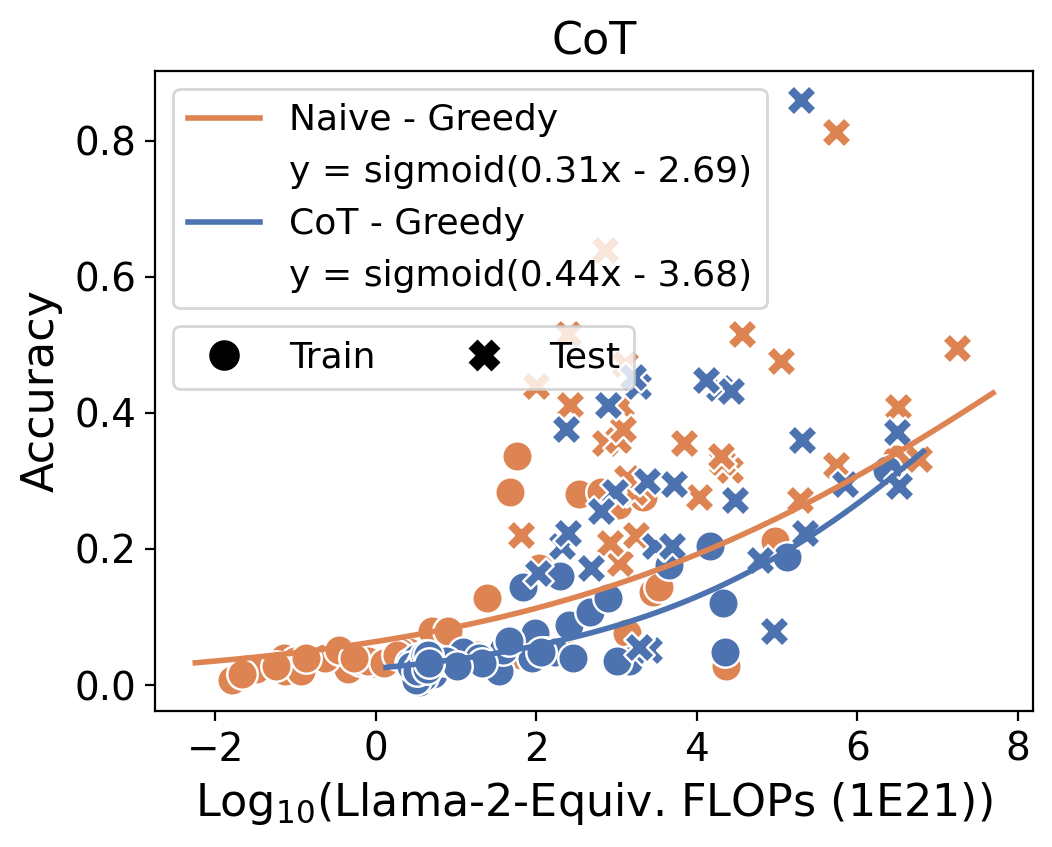

In [9]:
## Note: BBH task named by "bbh_{fewshot|cot_fewshot}_{subtask|overall}_3_exact_match,flexible-extract[,norm]"
##       where "overall" is the arverage of all subtasks, and ",norm" means normalized by random performance

def plot_bbh_scaling_curves(task: str = "overall"):

    TASK = task
    BBH_PCA_PREPROCESS_KWARGS = DEFAULT_PCA_PREPROCESS_KWARGS.copy()
    BBH_PCA_PREPROCESS_KWARGS["imputation_metrics"] = ALL_BENCHMARK_METRIC_LIST
    BBH_PCA_PREPROCESS_KWARGS["pca_metrics"] = ALL_BENCHMARK_METRIC_LIST

    SCALING_SETUP_KWARGS = {
        # Data preprocessing: PCA imputation and extraction
        **BBH_PCA_PREPROCESS_KWARGS, 
        
        # Non-lineariy: sigmoid with parametrized scale and shift
        "nonlinearity": "sigmoid-parametric", 

        # Cutoff: 8.4E22 FLOPs corresponding to LLama-2 7B
        "split_method": "cutoff_by_FLOPs (1E21)",
        "cutoff_threshold": 84,

        # Model families: include all we have evaled
        "df_filter": lambda x: x['Model Family'].isin(EVAL_BASE_MODEL_FAMILIES),   
        "df_groupby": 'Model Family',  # group markers by model family

        # Regression: ordinary least squares
        "reg_method": "robust",  
        "reg_kwargs": {"delta": 1.0},  # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS
    }

    PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP = {
        f"bbh_fewshot_{TASK}_3_exact_match,flexible-extract,norm": "Naive - Greedy",
        f"bbh_cot_fewshot_{TASK}_3_exact_match,flexible-extract,norm": "CoT - Greedy",
    }
    PLOT_BBH_METHOD_SCALING_METRICS = list(PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP.keys())

    color_palette = sns.color_palette()

    PLOT_BBH_METHOD_SCALING_COLOR_MAP = {
        f'bbh_fewshot_{TASK}_3_exact_match,flexible-extract,norm': color_palette[1],
        f'bbh_cot_fewshot_{TASK}_3_exact_match,flexible-extract,norm': color_palette[0],
    }

    PLOT_BBH_SETUP_SPECIFIC_KWARGS = {}
    for e in PLOT_BBH_METHOD_SCALING_METRICS:
        PLOT_BBH_SETUP_SPECIFIC_KWARGS[e] = {
            "plot_adjust_kwargs": {"title": PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
        }

    fig, _ = plot_scaling_comparison_multi_metrics(
        base_llm_eval_with_post_training, PLOT_BBH_METHOD_SCALING_METRICS, [PC_METRIC_NUM_3], SCALING_SETUP_KWARGS, 
        y_metric_specific_kwargs=PLOT_BBH_SETUP_SPECIFIC_KWARGS,
        ymetric2title_map=PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP, ymetric2color_map=PLOT_BBH_METHOD_SCALING_COLOR_MAP,
        plot_title="CoT"
    )


    fig.savefig(f'/scratch2/jsalle/ObsScaling/notebooks/figures/bbh_{task}.png')
    return


for task in BBH_SUBTASKS:
    plot_bbh_scaling_curves(task)


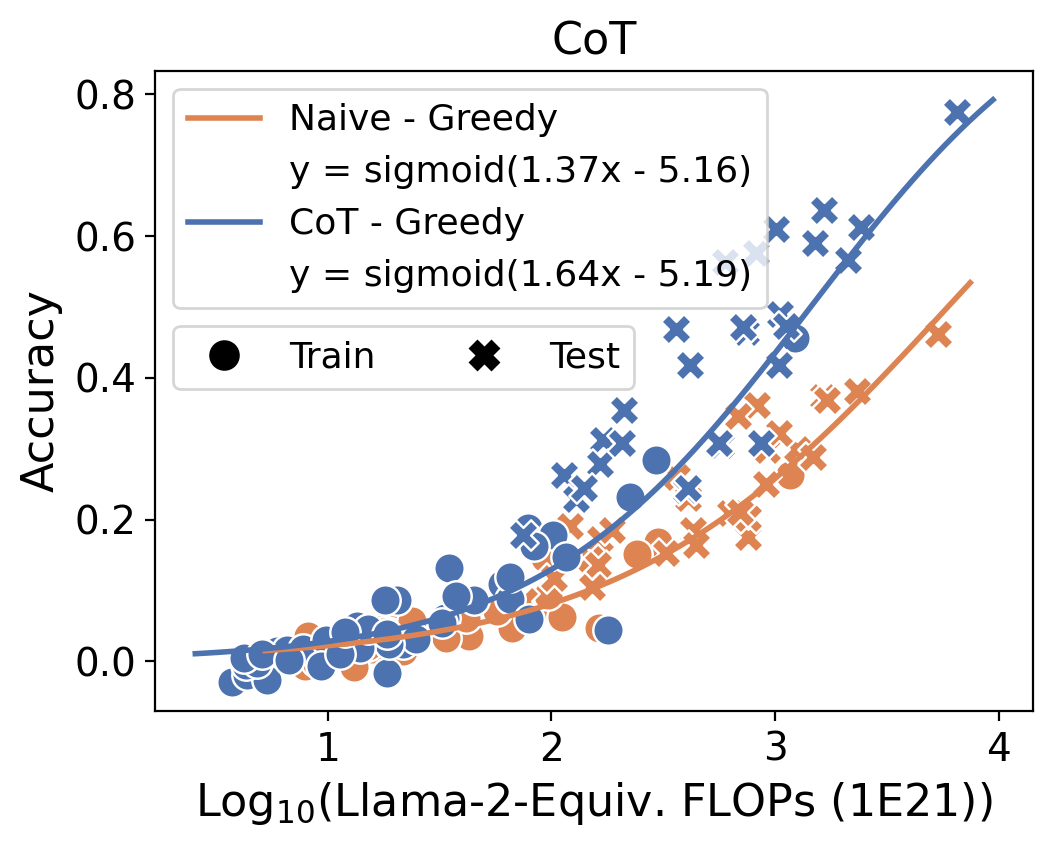

In [10]:
plot_bbh_scaling_curves(task='overall')